## 使用深度学习方法进行建模
#### 深度神经网络-多层感知机(MLP)

In [23]:
import pandas as pd
import numpy as np

data=pd.read_csv("dubai_properties.csv")
data.dropna(inplace=True)
print(data.head(3))
# data

                                             Address    Rent  Beds  Baths  \
0  The Gate Tower 2, The Gate Tower, Shams Gate D...  124000     3      4   
1                Water's Edge, Yas Island, Abu Dhabi  140000     3      4   
2            Al Raha Lofts, Al Raha Beach, Abu Dhabi   99000     2      3   

        Type  Area_in_sqft  Rent_per_sqft Rent_category Frequency  \
0  Apartment          1785      69.467787        Medium    Yearly   
1  Apartment          1422      98.452883        Medium    Yearly   
2  Apartment          1314      75.342466        Medium    Yearly   

    Furnishing   Purpose Posted_date  Age_of_listing_in_days        Location  \
0  Unfurnished  For Rent  2024-03-07                      45  Al Reem Island   
1  Unfurnished  For Rent  2024-03-08                      44      Yas Island   
2    Furnished  For Rent  2024-03-21                      31   Al Raha Beach   

        City   Latitude  Longitude  
0  Abu Dhabi  24.493598  54.407841  
1  Abu Dhabi  24.49

In [24]:
# 查看数据类型
print(data.dtypes)

Address                    object
Rent                        int64
Beds                        int64
Baths                       int64
Type                       object
Area_in_sqft                int64
Rent_per_sqft             float64
Rent_category              object
Frequency                  object
Furnishing                 object
Purpose                    object
Posted_date                object
Age_of_listing_in_days      int64
Location                   object
City                       object
Latitude                  float64
Longitude                 float64
dtype: object


In [25]:
### 编码分类特征

# for column, le in label_encoders.items():
#     num_classes = len(le.classes_)
#     print(f"列 '{column}' 有 {num_classes} 种分类。")


In [26]:
from sklearn.preprocessing import LabelEncoder

## 对非数值类型的特征进行分类编码

# 创建一个字典来存储每个特征的编码器
encoders = {}
# 遍历每列
for column in data.columns:
    # 如果是对象类型（通常是字符串或混合类型）
    if data[column].dtype == object:
        # 创建一个 LabelEncoder
        encoder = LabelEncoder()
        # 对当前列进行编码
        data[column] = encoder.fit_transform(data[column])
        # 保存编码器以便后续使用
        encoders[column] = encoder
    elif data[column].dtype == 'int64' or data[column].dtype == 'float64':
        # 数值类型，不需要编码
        pass
    else:
        print(f"Warning: Unhandled data type for column '{column}'")
        
# 查看数据
print(data.head(2))
print(data.dtypes)

   Address    Rent  Beds  Baths  Type  Area_in_sqft  Rent_per_sqft  \
0     3905  124000     3      4     0          1785      69.467787   
1     4219  140000     3      4     0          1422      98.452883   

   Rent_category  Frequency  Furnishing  Purpose  Posted_date  \
0              2          0           1        0          503   
1              2          0           1        0          504   

   Age_of_listing_in_days  Location  City   Latitude  Longitude  
0                      45       135     0  24.493598  54.407841  
1                      44       353     0  24.494022  54.607372  
Address                     int32
Rent                        int64
Beds                        int64
Baths                       int64
Type                        int32
Area_in_sqft                int64
Rent_per_sqft             float64
Rent_category               int32
Frequency                   int32
Furnishing                  int32
Purpose                     int32
Posted_date          

In [27]:
# 将编码后的数据保存到CSV文件，便于其他程序调用
encoded_data_file = 'encoded_dataset.csv'
data.to_csv(encoded_data_file, index=False)

print(f"Encoded data saved to {encoded_data_file}")

Encoded data saved to encoded_dataset.csv


In [28]:
# 准备特征和目标变量
X = data.drop(['Rent'],  axis=1)
y = data['Rent']
# # 根据分类剔除分类为1的维度
# X = X.drop(['Frequency', 'Purpose'], axis=1)
print(X.head(2))
print(y.head(2))

   Address  Beds  Baths  Type  Area_in_sqft  Rent_per_sqft  Rent_category  \
0     3905     3      4     0          1785      69.467787              2   
1     4219     3      4     0          1422      98.452883              2   

   Frequency  Furnishing  Purpose  Posted_date  Age_of_listing_in_days  \
0          0           1        0          503                      45   
1          0           1        0          504                      44   

   Location  City   Latitude  Longitude  
0       135     0  24.493598  54.407841  
1       353     0  24.494022  54.607372  
0    124000
1    140000
Name: Rent, dtype: int64


In [29]:
from sklearn.preprocessing import StandardScaler
# 使用标准归一化器
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

print(X_scaled[:2])
print(X_scaled.shape)
print(y.shape)

[[ 1.47687015  0.5381336   0.83981347 -0.53658716 -0.08421462 -0.28621261
   1.20988169  0.          0.52157908  0.          0.43296941 -0.40208572
  -0.84502384 -1.18090496 -0.74704453 -0.98711226]
 [ 1.72925982  0.5381336   0.83981347 -0.53658716 -0.20618471  0.14882219
   1.20988169  0.          0.52157908  0.          0.44833278 -0.41600607
   1.69240706 -1.18090496 -0.7463     -0.68188639]]
(73023, 16)
(73023,)


In [30]:
# 归一化正确，将y也归一化处理
y_from_to_frame = y.to_frame()
print(y_from_to_frame.shape)
y_scaled = standard_scaler.fit_transform(y_from_to_frame)
print(y_scaled[:2])

(73023, 1)
[[-0.07906335]
 [-0.02715964]]


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42) # 批量归一化
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # 非批量归一化
# X_train_tensor = torch.FloatTensor(X_train.values)
# y_train_tensor = torch.FloatTensor(y_train.values)
# X_test_tensor = torch.FloatTensor(X_test.values)
# y_test_tensor = torch.FloatTensor(y_test.values)

print(X_train_tensor[:3].numpy())
print("训练集特征张量大小", X_train_tensor.size())
print("训练集目标张量大小", y_train_tensor.size())
print("测试集特征张量大小:", X_test_tensor.size())
print("测试集目标张量大小:", y_test_tensor.size())

[[ 0.26395294 -1.3711756  -1.0110441  -0.5365872  -0.46558115 -0.47449508
  -0.0099224   0.          0.5215791   0.          0.5251496  -0.48560783
  -1.694714   -1.180905   -0.78964376 -1.0774182 ]
 [ 1.6480771  -1.3711756  -0.3940916  -0.5365872  -0.52505416  1.6856266
   1.2098817   0.         -1.9172548   0.          0.01815861 -0.02623618
  -0.12336918  0.35166693  0.4750966   0.3238181 ]
 [-1.1756327   0.5381336   0.8398135  -0.5365872   0.46280274 -0.2734313
  -1.2297266   0.          0.5215791   0.         -1.8100816   1.6302859
  -1.0196177  -1.180905   -0.7605115  -0.6917267 ]]
训练集特征张量大小 torch.Size([65720, 16])
训练集目标张量大小 torch.Size([65720, 1])
测试集特征张量大小: torch.Size([7303, 16])
测试集目标张量大小: torch.Size([7303, 1])


In [32]:
# 构建神经网络
class RentPredictor(nn.Module):
    def __init__(self, input_dim):
        super(RentPredictor, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Linear(256, 64)
        self.layer5 = nn.Linear(64, 1)
        self.swish = nn.SiLU()
    
    def forward(self, x):
        x = self.swish(self.layer1(x))
        x = self.swish(self.layer2(x))
        x = self.swish(self.layer3(x))
        x = self.swish(self.layer4(x))
        x = self.layer5(x)
        return x

In [33]:
from torch.utils.data import DataLoader

# 将模型放到GPU上运行    
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")


# 将数据也送到GPU
X_train_tensor_gpu = X_train_tensor.to(device)
X_test_tensor_gpu = X_test_tensor.to(device)
y_train_tensor_gpu = y_train_tensor.to(device)
y_test_tensor_gpu = y_test_tensor.to(device)

# 创建数据加载器，指定批量大小
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train_tensor_gpu, y_train_tensor_gpu)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor_gpu, y_test_tensor_gpu)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # 关闭打乱

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [34]:
# 实例化模型
print(f"shape X_train_tensor_gpu: {X_train_tensor_gpu.shape}")
# print(f"shape[0] y_test_tensor_gpu: {y_test_tensor_gpu.shape[0]}")
model = RentPredictor(X_train_tensor.shape[1]).to(device)

# 定义损失函数
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()

# 定义优化器
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer = optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.01)
# optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)
# optimizer = optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = optim.NAdam(model.parameters(), lr=0.002, betas=(0.9, 0.999))

# 定义训练轮数
epochs = 100

shape X_train_tensor_gpu: torch.Size([65720, 16])


In [35]:
from sklearn.metrics import mean_squared_error, r2_score

# 存储训练log
loss_values = []
mse_values = []
rmse_values = []
r2_values = []

# 训练模型
for epoch in range(epochs):
    # 训练模式
    model.train()
    for batch in train_data_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        # 前向传播
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        # 反向传播
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    # 评估模式
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor.to(device))
        # 将预测结果从GPU复制到CPU
        y_val_pred_cpu = y_val_pred.to('cpu')
        # 将预测结果转换为Numpy数组
        y_val_pred_numpy = y_val_pred_cpu.numpy()
        # 安全地使用y_val_pred_numpy作为mean_squared_error的输入
        mse_lr = mean_squared_error(y_test, y_val_pred_numpy)
        rmse_lr = np.sqrt(mse_lr)
        r2_lr = r2_score(y_test, y_val_pred_numpy)
        
        mse_values.append(mse_lr)
        rmse_values.append(rmse_lr)
        r2_values.append(r2_lr)

Epoch 5/100, Loss: 0.041712094098329544
Epoch 10/100, Loss: 0.016067752614617348
Epoch 15/100, Loss: 0.018207944929599762
Epoch 20/100, Loss: 0.0031911577098071575
Epoch 25/100, Loss: 0.002069780370220542
Epoch 30/100, Loss: 0.0021041734144091606
Epoch 35/100, Loss: 0.0016534667229279876
Epoch 40/100, Loss: 0.002344981301575899
Epoch 45/100, Loss: 0.001045149052515626
Epoch 50/100, Loss: 0.005397606175392866
Epoch 55/100, Loss: 0.001871376414783299
Epoch 60/100, Loss: 0.0019194360356777906
Epoch 65/100, Loss: 0.0007780854357406497
Epoch 70/100, Loss: 0.0011432099854573607
Epoch 75/100, Loss: 0.0022565736435353756
Epoch 80/100, Loss: 0.0014587447512894869
Epoch 85/100, Loss: 0.0016905926167964935
Epoch 90/100, Loss: 0.000369048590073362
Epoch 95/100, Loss: 0.0006714689661748707
Epoch 100/100, Loss: 0.0026586197782307863


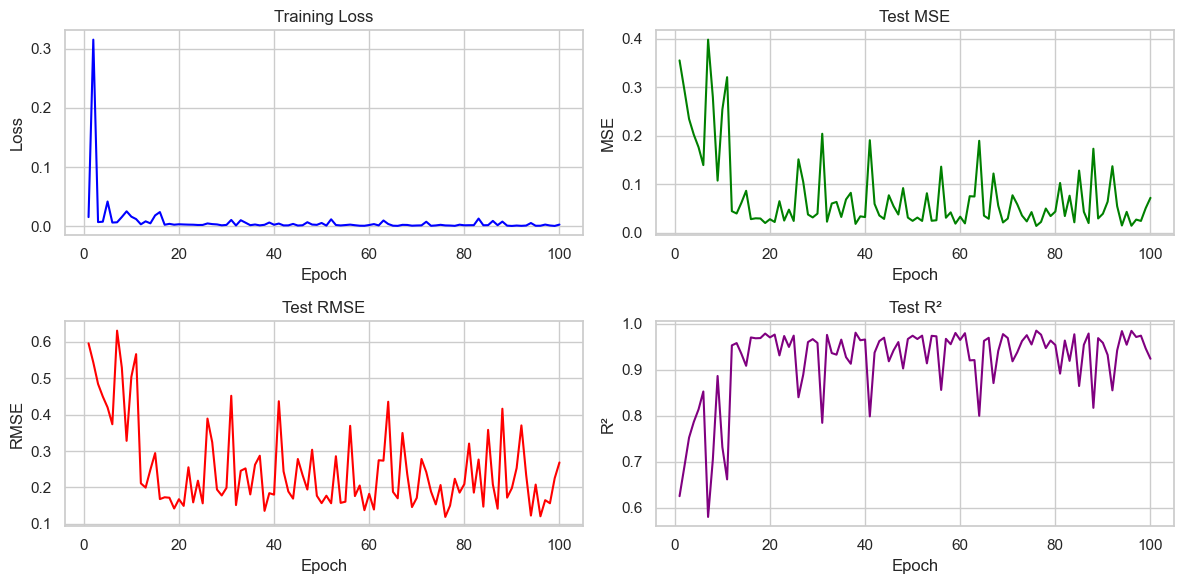

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制2x2的图表矩阵
plt.figure(figsize=(12, 6))

# 绘制训练损失曲线
ax1 = plt.subplot(2, 2, 1)
plt.plot(range(1, epochs + 1), loss_values, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制MSE曲线
ax2 = plt.subplot(2, 2, 2)
plt.plot(range(1, epochs + 1), mse_values, label='Test MSE', color='green')
plt.title('Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

# 绘制RMSE曲线
ax3 = plt.subplot(2, 2, 3)
plt.plot(range(1, epochs + 1), rmse_values, label='Test RMSE', color='red')
plt.title('Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

# 绘制R²曲线
ax4 = plt.subplot(2, 2, 4)
plt.plot(range(1, epochs + 1), r2_values, label='Test R²', color='purple')
plt.title('Test R²')
plt.xlabel('Epoch')
plt.ylabel('R²')

# 调整布局并显示图表
plt.tight_layout()
plt.show()

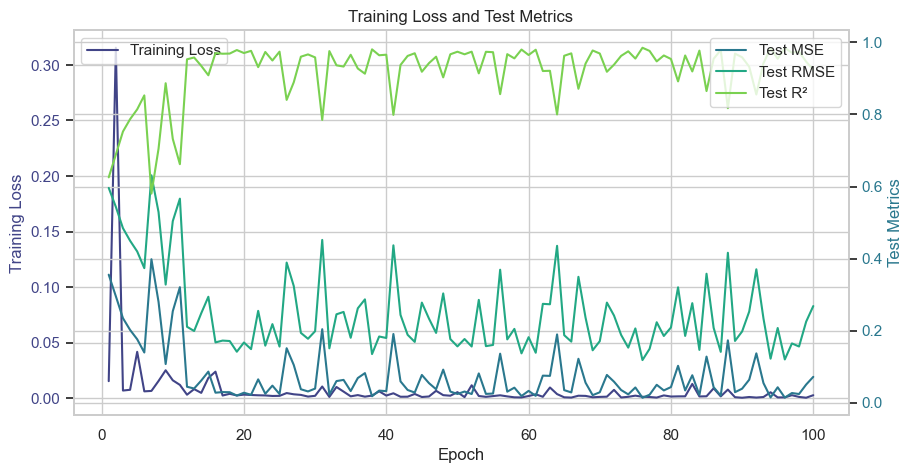

In [37]:
# 设置seaborn样式
sns.set(style="whitegrid")

# 创建一个图和轴用于绘制训练损失
# viridis:高对比度的颜色方案
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=sns.color_palette("viridis", 4)[0])
ax1.plot(range(1, epochs + 1), loss_values, label='Training Loss', color=sns.color_palette("viridis", 4)[0])
ax1.tick_params(axis='y', labelcolor=sns.color_palette("viridis", 4)[0])
ax1.legend(loc='upper left')


# 创建一个新的轴用于绘制其他指标，共享x轴
ax2 = ax1.twinx()  
ax2.set_ylabel('Test Metrics', color=sns.color_palette("viridis", 4)[1])
ax2.plot(range(1, epochs + 1), mse_values, label='Test MSE', color=sns.color_palette("viridis", 4)[1])
ax2.plot(range(1, epochs + 1), rmse_values, label='Test RMSE', color=sns.color_palette("viridis", 4)[2])
ax2.plot(range(1, epochs + 1), r2_values, label='Test R²', color=sns.color_palette("viridis", 4)[3])
ax2.tick_params(axis='y', labelcolor=sns.color_palette("viridis", 4)[1])
ax2.legend(loc='upper right')

# 添加标题
plt.title('Training Loss and Test Metrics')

# 显示图表
plt.show()

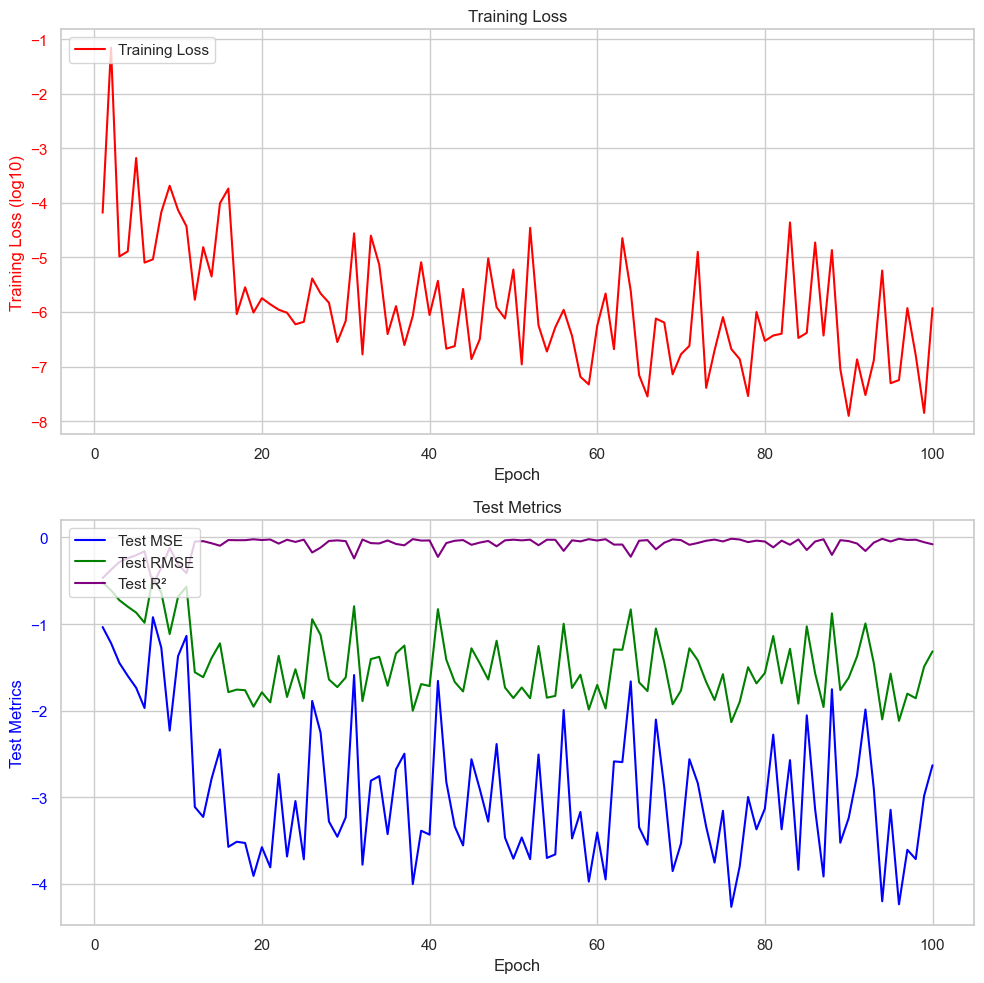

In [38]:
# 重绘可视化数据
# 设置seaborn样式
sns.set(style="whitegrid")

# 创建一个图和两个轴用于绘制训练损失和其他指标
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# 对数变换
log_loss_values = np.log(loss_values)
# 绘制训练损失曲线
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (log10)', color='red')
ax1.plot(range(1, len(log_loss_values) + 1), log_loss_values, label='Training Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')

# 对数变换
log_mse_values = np.log(mse_values)
log_rmse_values = np.log(rmse_values)
log_r2_values = np.log(r2_values)
# 绘制MSE曲线
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Metrics', color='blue')
ax2.plot(range(1, epochs + 1), log_mse_values, label='Test MSE', color='blue')
ax2.plot(range(1, epochs + 1), log_rmse_values, label='Test RMSE', color='green')
ax2.plot(range(1, epochs + 1), log_r2_values, label='Test R²', color='purple')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper left')

# 添加标题
ax1.set_title('Training Loss')
ax2.set_title('Test Metrics')

# 显示图表
plt.tight_layout()
plt.show()

In [39]:
# 5. 计算指标
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor_gpu)
    # print(f"shape: {y_test_pred.shape}")
    test_loss = criterion(y_test_pred, y_test_tensor_gpu.unsqueeze(1))
    # print(f"shape: {y_test_tensor_gpu.shape}")
    mse = test_loss.item()
    rmse = torch.sqrt(test_loss).item()
# 打印指标
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')

Test MSE: 1.844637393951416
Test RMSE: 1.3581743240356445


d:\ProgramData\anaconda3\envs\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7303, 1, 1])) that is different to the input size (torch.Size([7303, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [40]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_test_tensor.to(device))
    
# 将预测结果从GPU复制到CPU
y_val_pred_cpu = y_val_pred.to('cpu')

# 将预测结果转换为Numpy数组
y_val_pred_numpy = y_val_pred_cpu.numpy()

# 安全地使用y_val_pred_numpy作为mean_squared_error的输入
mse_lr = mean_squared_error(y_test, y_val_pred_numpy)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_val_pred_numpy)

# 计算sMAPE
abs_diff = np.abs(y_test - y_val_pred_numpy)
avg_abs = (np.abs(y_test) + np.abs(y_val_pred_numpy)) / 2
sMAPE = np.mean((abs_diff / avg_abs) * 100)

# 打印指标
print(f'Test MSE: {mse_lr}')
print(f'Test RMSE: {rmse_lr}')
print(f'Test R²: {r2_lr}')
print(f'Test sMAPE: {sMAPE}')

Test MSE: 0.07205932589585973
Test RMSE: 0.26843868181739333
Test R²: 0.9241233228967163
Test sMAPE: 18.82739051688738


In [41]:
# 查看模型参数
for name, param in model.named_parameters():
    print(f"{name}:", param.size())

layer1.weight: torch.Size([64, 16])
layer1.bias: torch.Size([64])
layer2.weight: torch.Size([128, 64])
layer2.bias: torch.Size([128])
layer3.weight: torch.Size([256, 128])
layer3.bias: torch.Size([256])
layer4.weight: torch.Size([64, 256])
layer4.bias: torch.Size([64])
layer5.weight: torch.Size([1, 64])
layer5.bias: torch.Size([1])


In [42]:
# 选择测试集中的几个样本
X_test_sample = X_test_tensor_gpu[:5]  # 选择前5个样本
y_test_sample = y_test_tensor_gpu[:5]

# 使用模型进行预测
with torch.no_grad():  # 确保不计算梯度
    y_pred_sample = model(X_test_sample)

# 将预测结果和实际目标值转换为 NumPy 数组
y_pred_sample_np = y_pred_sample.cpu().numpy()
y_test_sample_np = y_test_sample.cpu().numpy()

# 反归一化
y_pred_original = standard_scaler.inverse_transform(y_pred_sample_np)
y_test_original = standard_scaler.inverse_transform(y_test_sample_np)

# 打印反归一化后的预测结果和实际目标值
print('反归一化后的预测结果:', y_pred_original)
print('反归一化后的实际目标值:', y_test_original)


反归一化后的预测结果: [[238525.8 ]
 [ 52474.77]
 [ 96319.48]
 [138634.62]
 [132734.06]]
反归一化后的实际目标值: [[230000.   ]
 [ 45000.004]
 [ 90000.   ]
 [135000.   ]
 [135000.   ]]


In [43]:
# 获取模型的所有参数
parameters = list(model.parameters())

# 将所有参数打包成一个向量
parameters_vector = torch.cat([p.view(-1) for p in parameters])

# 计算参数量
num_parameters = parameters_vector.numel()

print(f"The model has {num_parameters} parameters.")

The model has 58945 parameters.


In [44]:
import datetime
# 保存模型

# 获取当前日期和时间
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# 结合模型名称和日期时间
model_name = 'MLP_Standard_Adamw'
model_file_name = f"pre_models/MLP/{model_name}_R{r2_lr:.3f}_B{batch_size}_S{sMAPE:.1f}.pth"

# 保存模型
torch.save(model, model_file_name)

print(f"Model saved as {model_file_name}")

Model saved as pre_models/MLP/MLP_Standard_Adamw_R0.924_B128_S18.8.pth
